In [1]:
import scipy.io as sio
import random as rnd
import collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
'''
helper functions:

med_disc_G(proto_a, proto_b, points)
INPUTS: take the prototype from class a and mean from class b, and all the points
OUPUT: Distance matrix (a-b)
PURPOSE: calculate the MED distance for each point

plot_discriminants(mesh_points, class_matrix)
INPUTS: mesh points and class matrix for each point in the mesh grid
PURPOSE: plot the contour graph
'''
def med_disc_G(proto_a, proto_b, points):
    x_prototype_a = np.subtract(points, np.array(proto_a))
    x_prototype_b = np.subtract(points, np.array(proto_b))
    dist_a = np.sqrt(np.sum(x_prototype_a * x_prototype_a, axis=1))
    dist_b = np.sqrt(np.sum(x_prototype_b * x_prototype_b, axis=1))
    dist_matrix = dist_a - dist_b
    return dist_matrix

def plot_discriminants(mesh_points, class_matrix):
    fig, ax = plt.subplots()
    ax.plot(class_a[:,0], class_a[:,1], "b.", label='Class A')
    ax.plot(class_b[:,0], class_b[:,1], 'r.', label='Class B')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Discriminants')
    ax.contourf(mesh_points[:,0].reshape(steps,steps), mesh_points[:,1].reshape(steps,steps), class_matrix.reshape(steps,steps), linewidths=0.5, cmap="Pastel1", levels=2)
    ax.legend()
    plt.show()

In [3]:
'''
classifier functions:

sequentialClassifier(class_a, class_b, J_max=np.inf, plot_graph=False)
INPUTS: all the points in class a and b and two optional inputs (J_max, plot_graph) 
plot_graph=True is for debugging purpose, so that you can see the discriminant function step by step, the default is False (no graphs)
J_max is to limit the total number of sequential classifiers. The default is infinity until the one of the classes is empty.
OUPUT: G_j (list of G, which are points from class a and b), n_aB_ (list of n_aB), n_bA_ (list of n_bA)
PURPOSE: train the data, calculate G, n_aB and n_bA

pointClassifier(all_points, G_j, naB_, nbA_)
INPUTS: all the points that need to be classified and output from the sequential Classifier
PURPOSE: take the result from sequentialClassifier function and classify each point
'''
def sequentialClassifier(class_a, class_b, J_max=np.inf, plot_graph=False):
    G_j = []
    naB_ = []
    nbA_ = []
    class_a_copy = class_a
    class_b_copy = class_b
    j_val = 1
    optimized = False
    while optimized == False and j_val <= J_max:

        # randomly choose one point from each class
        rng_a = rnd.choice(class_a_copy)
        rng_b = rnd.choice(class_b_copy)

        # define class a as -1, class b as 1
        true_a = np.negative(np.ones((1,class_a_copy.shape[0])))
        true_b = np.ones((1,class_b_copy.shape[0]))

        # predict a and b
        predicted_a = med_disc_G(rng_a, rng_b, class_a_copy)
        predicted_b = med_disc_G(rng_a, rng_b, class_b_copy)
        predicted_a[predicted_a < 0] = -1
        predicted_a[predicted_a >= 0] = 1
        predicted_b[predicted_b < 0] = -1
        predicted_b[predicted_b >= 0] = 1

        # generate confusion matrix
        conf_mat_a = confusion_matrix(true_a.T, predicted_a)
        conf_mat_b = confusion_matrix(true_b.T, predicted_b)

        # calculate naB and nbA from the confusion matrix
        # naB = #times G classifies a point from class_a_copy as class B
        if conf_mat_a.shape[1] == 1: n_aB = 0
        else: n_aB = conf_mat_a[0][1]

        # nbA = #times G classifies a point from class_b_copy as class A
        if conf_mat_b.shape[1] == 1: n_bA = 0
        else: n_bA = conf_mat_b[1][0]

        if n_aB != 0 and n_bA != 0:
            optimized = False
        else:
            # plot, this is for debug purpose, to see each step
            if plot_graph == True:
                distance_matrix_mesh = med_disc_G(rng_a, rng_b, mesh_points)
                distance_matrix_mesh[distance_matrix_mesh <= 0] = -1 # class a
                distance_matrix_mesh[distance_matrix_mesh > 0] = 1 # class b
            # append G, naB and nbA to the result
            G_j.append([rng_a, rng_b])
            naB_.append(n_aB)
            nbA_.append(n_bA)

            # remove those points from b that G classifies as B
            if n_aB == 0:
                correct_indice_b = np.where(np.equal(true_b, predicted_b.T)==True)[1]
                class_b_copy = np.delete(class_b_copy, correct_indice_b, axis = 0)
            
            # remove those points from a that G classifies as A
            if n_bA == 0:
                correct_indice_a = np.where(np.equal(true_a, predicted_a.T)==True)[1]
                class_a_copy = np.delete(class_a_copy, correct_indice_a, axis=0)

            j_val = j_val + 1

            # check if any class is empty
            if class_a_copy.size == 0 or class_b_copy.size == 0:
                optimized = True
                print(f"Total number of iteration: {j_val}")
                print(f"class A has {class_a_copy.shape[0]} points left.")
                print(f"class B has {class_b_copy.shape[0]} points left.")
            else:
                optimized = False
    return G_j, naB_, nbA_

def pointClassifier(all_points, G_j, naB_, nbA_):
    result = []
    for p in all_points:
        r = 0
        for j, means in enumerate(G_j):
            G_a_mean = means[0]
            G_b_mean = means[1]
            pred_cls = med_disc_G(G_a_mean, G_b_mean, np.array([p]))
            if pred_cls[0] > 0 and naB_[j] == 0: 
                r = 1 #if Gj classifies x as class B and naBj =0 then say class B
                break
            if pred_cls[0] <= 0 and nbA_[j] == 0: 
                r = -1 #if Gj classifies x as class A and nbAj =0 then say class A
                break
        result.append(r)
    return result

In [4]:
#read data from .mat file
class_a = sio.loadmat('lab2_3.mat')['a'].astype('int64')
class_b = sio.loadmat('lab2_3.mat')['b'].astype('int64')

In [5]:
#generate mesh grid
x = np.concatenate((class_a,class_b), axis = 0)
x_1_min, x_1_max = x[:,0].min()-50, x[:,0].max()+100
x_2_min, x_2_max = x[:,1].min()-50, x[:,1].max()+100
steps = 1000
x_1_range = np.linspace(x_1_min, x_1_max, steps)
x_2_range = np.linspace(x_2_min, x_2_max, steps)
X_mesh, Y_mesh = np.meshgrid(x_1_range, x_2_range)
row = X_mesh.shape[0]
col = X_mesh.shape[1]
mesh_points = np.concatenate((X_mesh.reshape(row*col,1), Y_mesh.reshape(row*col,1)), axis = 1)

In [6]:
# Part4-Q1: run the sequential Classifiers three times for class a and b
G_j1, naB_1, nbA_1 = sequentialClassifier(class_a, class_b)
G_j2, naB_2, nbA_2 = sequentialClassifier(class_a, class_b)
G_j3, naB_3, nbA_3 = sequentialClassifier(class_a, class_b)

Total number of iteration: 9
class A has 0 points left.
class B has 0 points left.
Total number of iteration: 11
class A has 0 points left.
class B has 0 points left.
Total number of iteration: 12
class A has 0 points left.
class B has 0 points left.


In [7]:
# concatenate all the points from class a and b, also create true labels for each class
# class A is -1, class_B is 1
all_points = np.concatenate((class_a, class_b), axis = 0)
true_label = np.concatenate((np.negative(np.ones((1,class_a.shape[0]))), np.ones((1,class_b.shape[0]))), axis = 1)
mesh_points_class_1 = pointClassifier(mesh_points, G_j1, naB_1, nbA_1)
mesh_points_class_2 = pointClassifier(mesh_points, G_j2, naB_2, nbA_2)
mesh_points_class_3 = pointClassifier(mesh_points, G_j3, naB_3, nbA_3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: linewidths is ignored by contourf


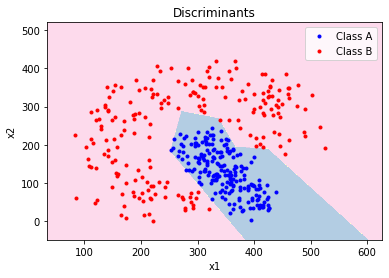

Sequential Classifier 1 error rate: 0.0


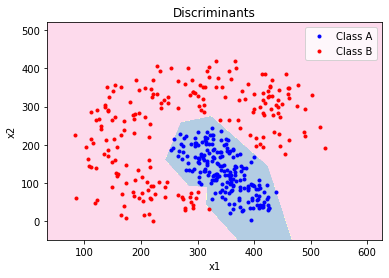

Sequential Classifier 2 error rate: 0.0


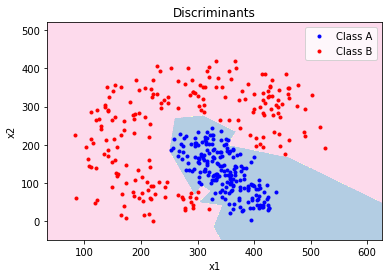

Sequential Classifier 3 error rate: 0.0


In [8]:
# Plot the decision boundary for three sequential classifiers
# Part4-Q2: Print the error rate along with graph
plot_discriminants(mesh_points, np.array(mesh_points_class_1))
predicted_class_1 = pointClassifier(all_points, G_j1, naB_1, nbA_1)
error_1 = 1 - accuracy_score(true_label.T, predicted_class_1)
print(f"Sequential Classifier 1 error rate: {error_1}")

plot_discriminants(mesh_points, np.array(mesh_points_class_2))
predicted_class_2 = pointClassifier(all_points, G_j2, naB_2, nbA_2)
error_2 = 1 - accuracy_score(true_label.T, predicted_class_2)
print(f"Sequential Classifier 2 error rate: {error_2}")

plot_discriminants(mesh_points, np.array(mesh_points_class_3))
predicted_class_3 = pointClassifier(all_points, G_j3, naB_3, nbA_3)
error_3 = 1 - accuracy_score(true_label.T, predicted_class_3)
print(f"Sequential Classifier 3 error rate: {error_3}")

In [9]:
# Part4-Q3: limit the number of sequential classiers until J = 5, and learn them 20 times, find the average error rate, minimum error rate, maximum error rate and standard deviation of error rate
J_max = 5
time_of_learning = 20
error_array = np.zeros((J_max, time_of_learning))

for index in range(time_of_learning):
    #loop through J_max
    for j in range(1,J_max+1):
        G_j, naB_, nbA_ = sequentialClassifier(class_a, class_b, J_max=j)
        predicted_class = pointClassifier(all_points, G_j, naB_, nbA_)
        conf = confusion_matrix(true_label.T, predicted_class)
        error = 1 - accuracy_score(true_label.T, predicted_class)
        error_array[j-1][index] = error
min_array = np.amin(error_array, axis=1)
max_array = np.amax(error_array, axis=1)
avg_array = np.average(error_array, axis=1)
std_array = np.std(error_array, axis=1)
j_array = np.arange(1,J_max+1, 1)

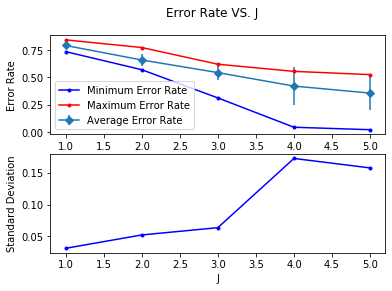

In [10]:
# Plot the error graph
fig=plt.figure()
axes = plt.axes()
fig.suptitle('Error Rate VS. J')
plt.subplot(2,1,1)
plt.xlabel("J")
plt.ylabel("Error Rate")
plt.plot(j_array, min_array, "b.", linestyle='-', label='Minimum Error Rate')
plt.plot(j_array, max_array, "r.", linestyle='-', label='Maximum Error Rate')
plt.errorbar(j_array, avg_array, std_array, linestyle='-', marker='D', label="Average Error Rate")
axes.set_ylim([0, 1.1])
plt.legend()
plt.subplot(2,1,2)
plt.plot(j_array, std_array, "b.", linestyle='-', label='Standard Deviation of Error Rate')
plt.xlabel("J")
plt.ylabel("Standard Deviation")
plt.show()